# Is it a bird? Creating a model from your own data

### Etapa 1: Download de imagens: birds e non-birds

#### Import inicial

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Busca por 'bird photos'

In [5]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

#### Visualizando imagem encontrada

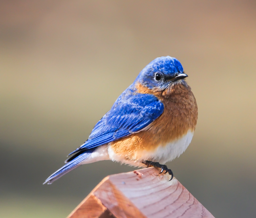

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### Busca por 'forest photos'

Searching for 'forest photos'


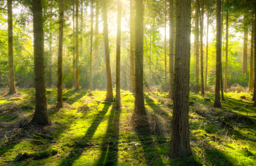

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

#### Construindo banco de imagens

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


### Etapa 2: Treinando o modelo

#### Verificando e 'limpando' imagens com problema

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

#### Separando imagens em conjuntos de treino e validação

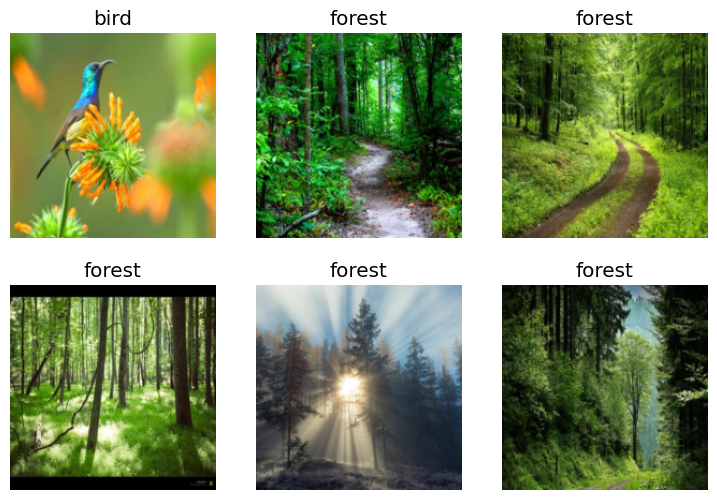

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#### Treinando e 'tunando' o modelo

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\keng/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 47.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.839581,0.282473,0.060606,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.188269,0.129971,0.030303,00:07
1,0.102880,0.086682,0.030303,00:07
2,0.071483,0.060843,0.030303,00:07


### Utilizando o modelo - checando na imagem baixada inicialmente 

In [13]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


# Não somente para reconhecimento de imagens

In [17]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(path, bs=8, 
                    fnames = get_image_files(path/'images'), label_func= lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                                             codes = np.loadtxt(path/'codes.txt', dtype=str))

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\keng/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:02<00:00, 33.9MB/s]


epoch,train_loss,valid_loss,time
0,3.799412,2.507774,00:19


epoch,train_loss,valid_loss,time
0,1.823578,1.460738,00:20
1,1.576321,1.228596,00:23
2,1.427866,1.245091,00:23
3,1.327115,0.964318,00:21
4,1.202466,0.863153,00:25
5,1.090425,0.815162,00:21
6,0.996521,0.788648,00:20
7,0.923058,0.783922,00:20


# Análises Tabulares

In [20]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names='salary', 
                        cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                        cont_names = ['age','fnlwgt', 'education-num'], procs = [Categorify, FillMissing, Normalize])

dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,26.000000,50052.997914,13.0,<50k
1,Private,Masters,Divorced,Sales,Not-in-family,White,False,47.000000,26949.998448,14.0,<50k
2,Private,Some-college,Never-married,Other-service,Own-child,White,False,20.999999,186647.999992,10.0,<50k
3,State-gov,HS-grad,Divorced,Adm-clerical,Unmarried,White,False,47.000000,108890.001010,9.0,<50k
4,?,Assoc-acdm,Married-civ-spouse,?,Husband,Black,False,54.999999,270227.997011,12.0,>=50k
5,Private,Bachelors,Never-married,Other-service,Unmarried,Asian-Pac-Islander,False,48.000000,102937.998747,13.0,<50k
6,Private,HS-grad,Married-civ-spouse,Other-service,Husband,White,False,31.000000,214234.999908,9.0,<50k
7,Private,11th,Never-married,Other-service,Not-in-family,Black,False,33.000000,78706.998979,7.0,<50k
8,?,Assoc-voc,Widowed,?,Not-in-family,White,False,67.000000,244121.998939,11.0,<50k
9,Private,12th,Never-married,Other-service,Not-in-family,White,False,22.000001,245524.001225,8.0,<50k


In [21]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.380448,0.373838,0.826474,00:02
1,0.355478,0.349285,0.835534,00:02


# Filtros colaborativos - sistema de recomendação 

In [25]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [26]:
dls.show_batch()

,userId,movieId,rating
0,247,1197,4.0
1,195,1270,3.0
2,358,1291,3.0
3,615,1200,4.0
4,587,593,4.0
5,472,6539,3.5
6,564,457,4.0
7,463,32,4.0
8,405,1036,4.0
9,564,1291,4.0


In [28]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.521033,1.369488,00:00


epoch,train_loss,valid_loss,time
0,1.376254,1.314532,00:00
1,1.274683,1.146411,00:00
2,1.031431,0.861729,00:00
3,0.793833,0.740476,00:00
4,0.685000,0.715378,00:00
5,0.644794,0.706095,00:00
6,0.617540,0.701709,00:00
7,0.614183,0.699410,00:00
8,0.607215,0.698728,00:00
9,0.601602,0.698621,00:00


In [30]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,30.0,67.0,4.0,4.246238
1,89.0,80.0,4.5,4.167982
2,8.0,23.0,2.0,3.178710
3,90.0,85.0,3.0,4.061706
4,21.0,4.0,1.0,3.301950
5,21.0,67.0,3.5,3.605845
6,37.0,52.0,4.0,4.190734
7,35.0,28.0,3.5,2.756530
8,30.0,47.0,5.0,4.616444
